<img src="proyecto_final_portada.png" alt="Portada Proyecto Final" style="height: 600px; width:600px;"/>



El sector de las telecomunicaciones (telecom) en India está cambiando rápidamente, con la creación de más y más empresas de telecomunicaciones y muchos clientes decidiendo cambiar entre proveedores. "Churn" se refiere al proceso en el que los clientes o suscriptores dejan de utilizar los servicios o productos de una empresa. Comprender los factores que influyen en la retención de clientes como también lograr predecir la posibilidad de "churn" es crucial para que las empresas de telecomunicaciones mejoren la calidad de sus servicios y la satisfacción del cliente. Como científicos de datos en este proyecto, nuestro objetivo es explorar la compleja dinámica del comportamiento y la demografía de los clientes en el sector de las telecomunicaciones en India para predecir la "salida" o "churn" de los clientes, utilizando dos conjuntos de datos completos de cuatro importantes socios de telecomunicaciones: Airtel, Reliance Jio, Vodafone y BSNL:

- `telecom_demographics.csv` contiene información relacionada con la demografía de los clientes indios:

| Variable             | Descripción                                      |
|----------------------|--------------------------------------------------|
| `customer_id `         | Identificador único de cada cliente.             |
| `telecom_partner `     | El socio de telecomunicaciones asociado con el cliente.|
| `gender `              | El género del cliente.                      |
| `age `                 | La edad del cliente.                         |
| `state`                | El estado indio en el que se encuentra el cliente.|
| `city`                 | La ciudad en la que se encuentra el cliente.       |
| `pincode`              | El código PIN de la ubicación del cliente.          |
| `registration_event` | Cuando el cliente se registró con el socio de telecomunicaciones.|
| `num_dependents`      | El número de dependientes (por ejemplo, niños) que tiene el cliente.|
| `estimated_salary`     | El salario estimado del cliente.                 |

- `telecom_usage` contiene información sobre los patrones de uso de los clientes indios:

| Variable   | Descripción                                                  |
|------------|--------------------------------------------------------------|
| `customer_id` | Identificador único de cada cliente.                         |
| `calls_made` | El número de llamadas realizadas por el cliente.                    |
| `sms_sent`   | El número de mensajes de SMS enviados por el cliente.             |
| `data_used`  | La cantidad de datos utilizada por el cliente.                     |
| `churn`    | Variable binaria que indica si el cliente ha cancelado o no (1 = cancelado, 0 = no cancelado).|

---

#### Estructura del notebook:
##### 1. Importación de librerías y dependencias 


In [1]:
#Importamos las librerías princiaples
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from machine_learning_utils import make_prediction, verify_results #Funciones que creamos para predecir y visualizar resultados en "machine_learning_utils.py"
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier


##### 2. Análisis exploratorio de los datos y variables relevantes


Leemos los datasets y procesamos los datos desde archivos locales .csv

In [2]:
#Lectura de los archivos .csv con pandas
df1 = pd.read_csv('telecom_demographics.csv')
df2 = pd.read_csv('telecom_usage.csv')

print(df1.shape, df2.shape)

(6500, 10) (6500, 5)


In [3]:
#Unimos los dos dataframes con la variable customer id
df_full = pd.merge(df1,df2,on='customer_id')
df_full.head(5)

,customer_id,telecom_partner,gender,age,state,city,pincode,registration_event,num_dependents,estimated_salary,calls_made,sms_sent,data_used,churn
0,15169,Airtel,F,26,Himachal Pradesh,Delhi,667173,2020-03-16,4,85979,75,21,4532,1
1,149207,Airtel,F,74,Uttarakhand,Hyderabad,313997,2022-01-16,0,69445,35,38,723,1
2,148119,Airtel,F,54,Jharkhand,Chennai,549925,2022-01-11,2,75949,70,47,4688,1
3,187288,Reliance Jio,M,29,Bihar,Hyderabad,230636,2022-07-26,3,34272,95,32,10241,1
4,14016,Vodafone,M,45,Nagaland,Bangalore,188036,2020-03-11,4,34157,66,23,5246,1


In [4]:
df_full.shape

(6500, 14)

El dataset tiene 6500 filas y 15 columnas luego del join

In [5]:
df_full.isna().sum()

customer_id           0
telecom_partner       0
gender                0
age                   0
state                 0
city                  0
pincode               0
registration_event    0
num_dependents        0
estimated_salary      0
calls_made            0
sms_sent              0
data_used             0
churn                 0
dtype: int64

In [6]:
df_full.duplicated().sum()

0

No hay valores vacíos ni tampoco repetidos o duplicados.

In [7]:
df_full= df_full.drop(axis=1, columns=['customer_id', 'pincode']) #Eliminamos customer_id que ya no nos sirve

Podemos comenzar entonces, con el Análisis estadístico de las variables númericas del dataset

In [8]:
df_full.describe(exclude='O') 

,age,num_dependents,estimated_salary,calls_made,sms_sent,data_used,churn
count,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000
mean,46.108615,1.982308,85529.193385,49.789538,24.257846,5000.956308,0.200462
std,16.443712,1.404659,37545.639180,29.799221,14.650736,2940.611928,0.400377
min,18.000000,0.000000,20001.000000,-10.000000,-5.000000,-969.000000,0.000000
25%,32.000000,1.000000,52905.000000,25.000000,12.000000,2493.750000,0.000000
50%,46.000000,2.000000,85286.500000,50.000000,25.000000,4975.500000,0.000000
75%,60.000000,3.000000,118817.500000,75.000000,37.000000,7504.250000,0.000000
max,74.000000,4.000000,149977.000000,108.000000,53.000000,10919.000000,1.000000


Algunos datos relevantes del análisis estadísitico de la distribución de los datos:
- La edad promedio de los clientes de 46 años. La edad mínima es 18 y la edad máxima es de 74

- Estimated salary como genralmente sucede con los salarios tiene una desviación estandar enorme, implicando un desbalance entre la distribución de los salarios. 

- Aparecen números negativos en el mínimo de llamadas hechas, sms enviados y en la cantidad de datos utilizados. Deberemos decidir como se interpretarán y usarán estos datos.



Análisis estadístico de las variables categóricas del dataset

In [9]:
df_full.describe(include='O').T

,count,unique,top,freq
telecom_partner,6500,4,Reliance Jio,1658
gender,6500,2,M,3909
state,6500,28,Karnataka,260
city,6500,6,Delhi,1128
registration_event,6500,1216,2021-04-04,14


El análisis de variables categóricas nos permite revisar la frecuencia y la cantidad de valores nulos:

 - No hay valores nulos, tenemos 4 empresas, 2 géneros y con mayor frecuencia masculinos.
 
 - La ciudad con más frecuencia es Delhi, relacionada con el estado Karnataka. 


In [10]:
sns.set_palette('deep') #Seteamos la paleta de colores

In [11]:
def vars_categoricas_graf(dataframe, x, y): #Función que permite graficar variables categóricas y ver la cantidad de renuncias por categoría
        if x == y:
                churn_counts = dataframe[x].value_counts().reset_index()
                churn_counts = churn_counts.replace({0:'No', 1: 'Sí'})
                sns.barplot(data=churn_counts, x='churn', y='count', hue='churn', legend=False)
                plt.ylabel('Cantidad de bajas de clientes')
                plt.xlabel('¿El cliente se dió la baja?')
                plt.show()
                print(churn_counts)

                
        else:   
                grouped_df = df_full.groupby(x)[y].sum().reset_index() #agrupamos y sumamos para obtener la cantidad total de bajas por variable categórica

                plt.subplots(figsize=(8,6))
                sns.barplot(data=grouped_df, x=x, y=y, hue=x, legend=False) #graficamos
                plt.xticks(rotation=90)
                plt.xlabel('Tipos de '+ x + ' diferentes')
                plt.ylabel('Cantidad de bajas de clientes')
                plt.show()
                print('Top 5 variables con mas churn', '\n', '\n', grouped_df.sort_values(by=y, ascending=False).head(5))

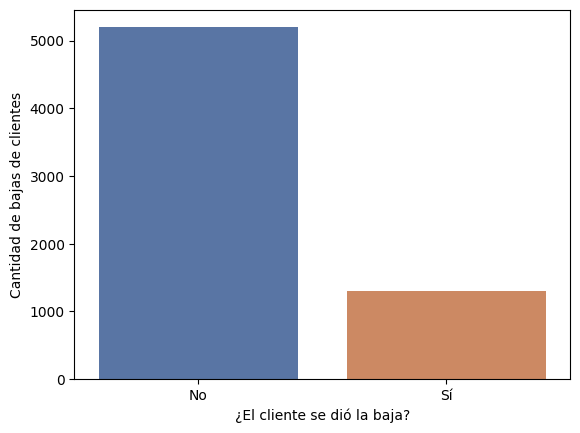

  churn  count
0    No   5197
1    Sí   1303


In [12]:
vars_categoricas_graf(df_full, 'churn', 'churn')

Podemos ver que nuestro tipo de predicción es hacia una clase desbalanceada, que representa aproximadamente el 20% del total de posibilidades.

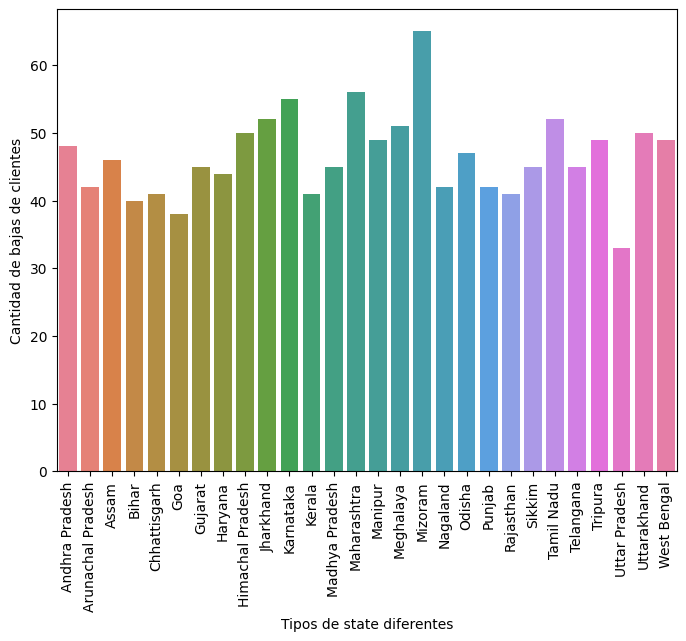

Top 5 variables con mas churn 
 
           state  churn
16      Mizoram     65
13  Maharashtra     56
10    Karnataka     55
22   Tamil Nadu     52
9     Jharkhand     52


In [13]:
vars_categoricas_graf(df_full, 'state', 'churn')

Parecer ser que el estado de Mizoram es el que mayor cantidad de bajas presentas, podría ser un dato clave para preguntar qué sucedió en las ciudades del estado.

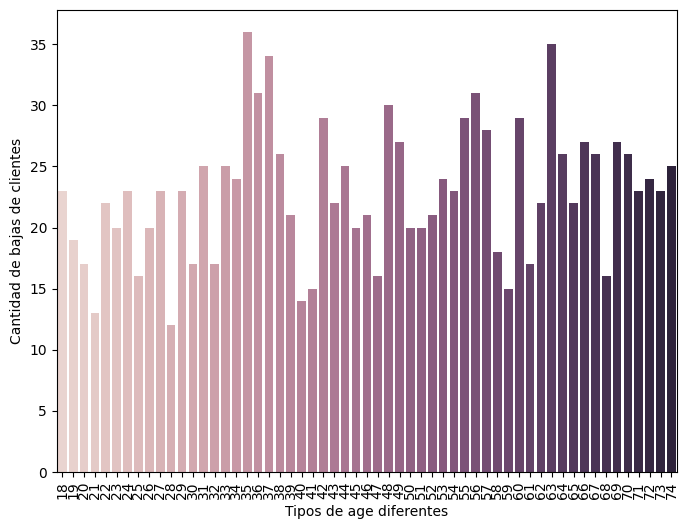

Top 5 variables con mas churn 
 
     age  churn
17   35     36
45   63     35
19   37     34
38   56     31
18   36     31


In [14]:
vars_categoricas_graf(df_full, 'age', 'churn')

Es interesante ver que hay un alto índice de renuncias entre los 35,36,37 años y los 56,60 y 63 años. 

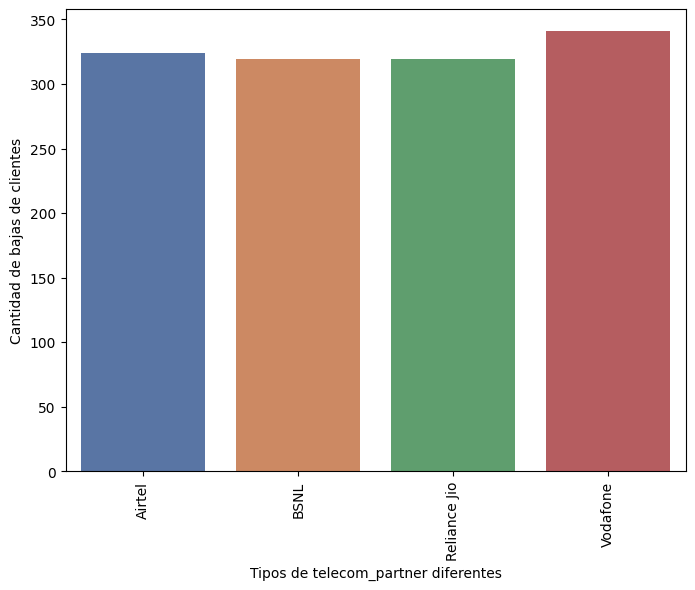

Top 5 variables con mas churn 
 
   telecom_partner  churn
3        Vodafone    341
0          Airtel    324
1            BSNL    319
2    Reliance Jio    319


In [15]:
vars_categoricas_graf(df_full, 'telecom_partner', 'churn')

In [16]:
df_full['telecom_partner'].value_counts()

telecom_partner
Reliance Jio    1658
BSNL            1635
Vodafone        1609
Airtel          1598
Name: count, dtype: int64

Si bien todas las empresas tienen una cantidad de renuncias similares, podemos ver que Vodafone lidera en las que más bajas tiene t podríamos decir que no es de las que más clientes tienen, esto es una llamada de atención para Vodafone.

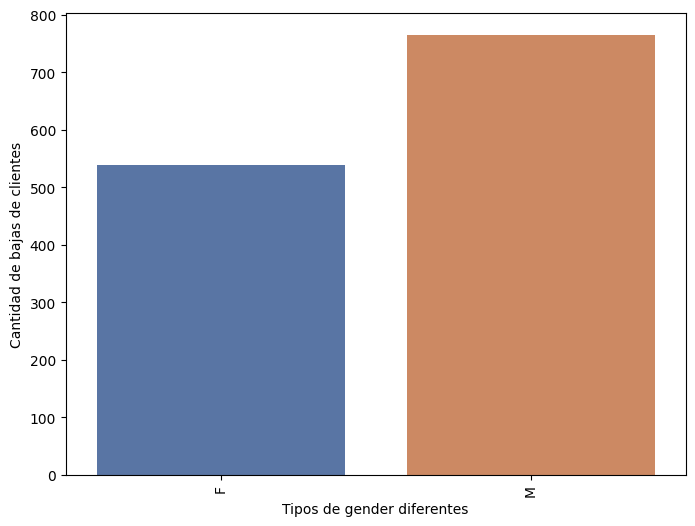

Top 5 variables con mas churn 
 
   gender  churn
1      M    765
0      F    538


In [17]:
vars_categoricas_graf(df_full, 'gender', 'churn')

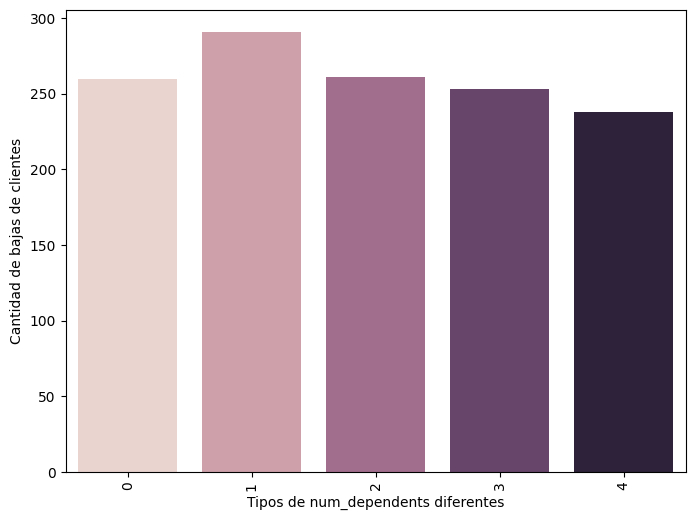

Top 5 variables con mas churn 
 
    num_dependents  churn
1               1    291
2               2    261
0               0    260
3               3    253
4               4    238


In [18]:
vars_categoricas_graf(df_full, 'num_dependents', 'churn')

Las personas con 1 hijo tienen mayor probabilidad de renunciar, sin embargo, no es una gran probabilidad, vemos una distribución similar entre los otras opciones.

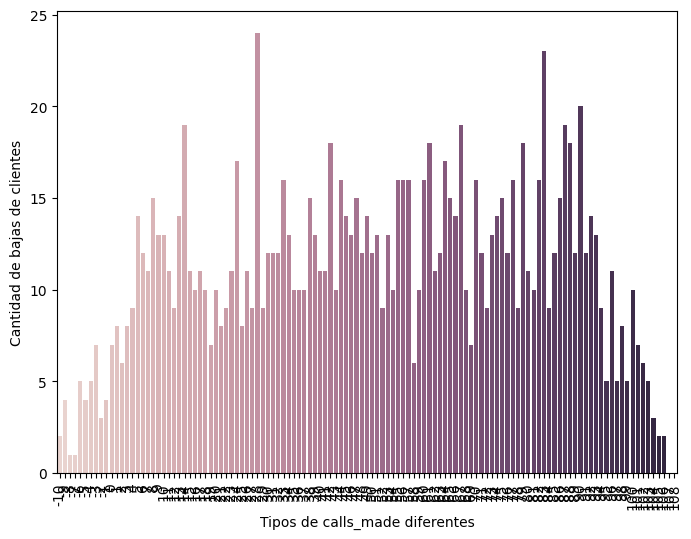

Top 5 variables con mas churn 
 
      calls_made  churn
38           28     24
93           83     23
100          90     20
24           14     19
97           87     19


In [19]:
vars_categoricas_graf(df_full, 'calls_made', 'churn')

Podemos ver que no hay una estricta relación entre la cantidad de llamadas y las bajas. 

Podemos notar que hay mayor bajas en niveles bajos y altos de llamadas realizadas. 

Esto puede que genere en las personas que llaman poco querer cambiar de plan (porque pueden estar pagando un precio más elevado del uso que le dan al servicio o bien, personas que realizan muchas llamadas y reciben facturas con precios muy elevados). 

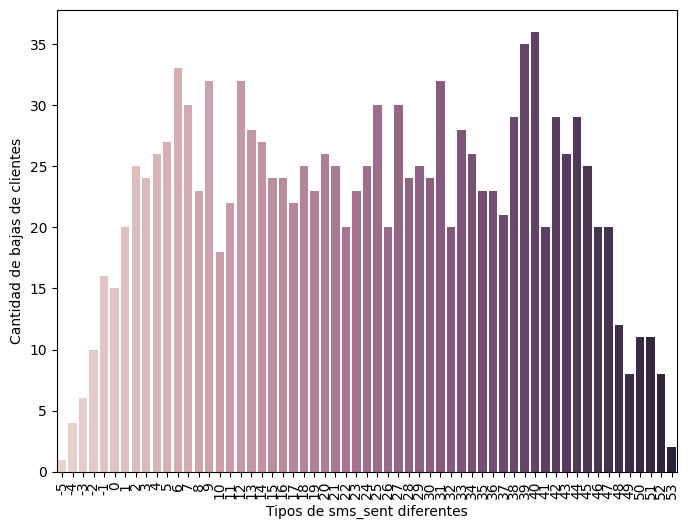

Top 5 variables con mas churn 
 
     sms_sent  churn
45        40     36
44        39     35
11         6     33
36        31     32
17        12     32


In [20]:
vars_categoricas_graf(df_full, 'sms_sent', 'churn')

En el caso de sms enviados, sucede algo muy similar con llamadas realizadas.

##### Veamos que sucede con la distribución de las variables númericas

In [21]:
def distribution_plot(df, column):
    plt.figure(figsize=(8, 6))
    sns.histplot(df[column], kde=True)
    plt.title(f'Distribución de {column}')
    plt.xlabel(column)
    plt.ylabel('Frecuencia')
    plt.show()

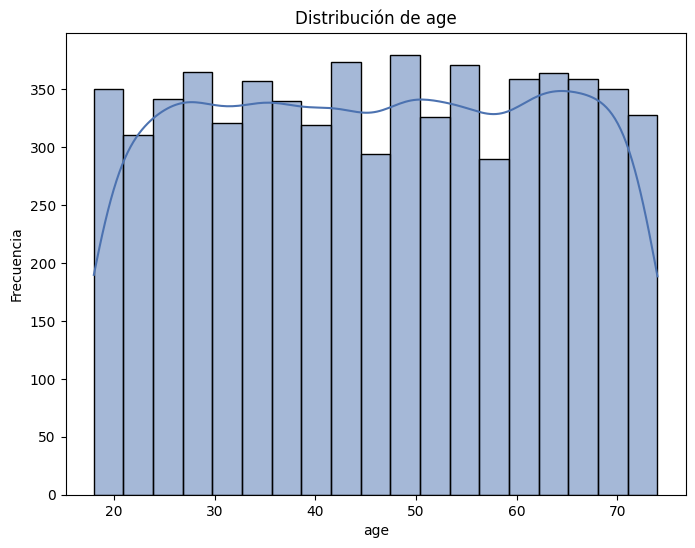

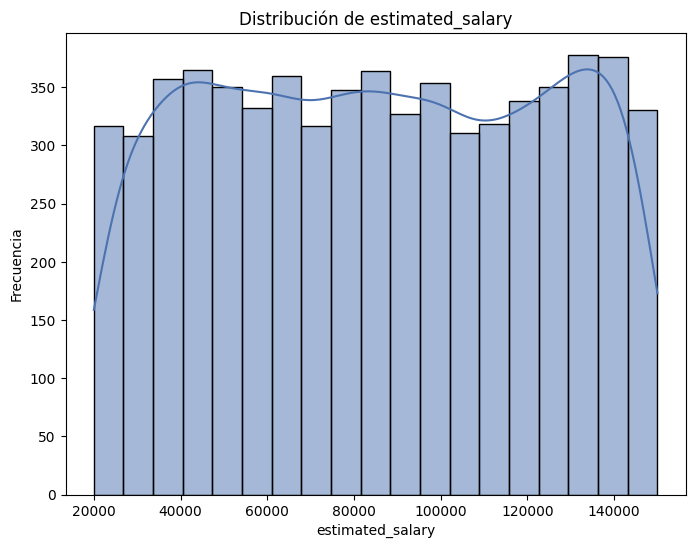

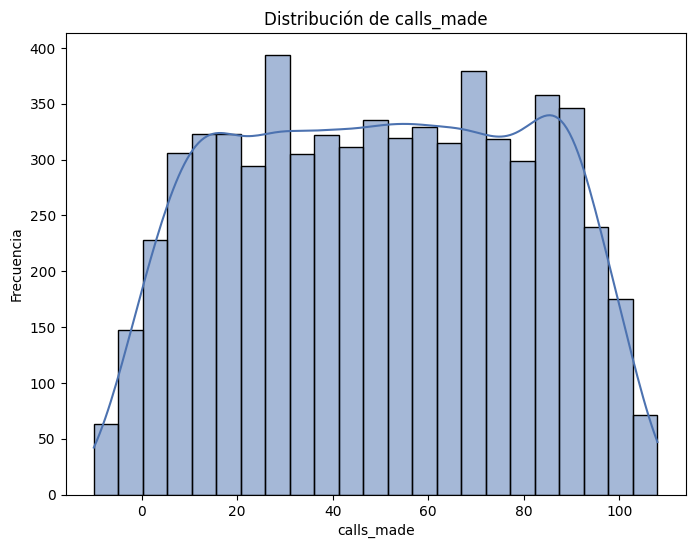

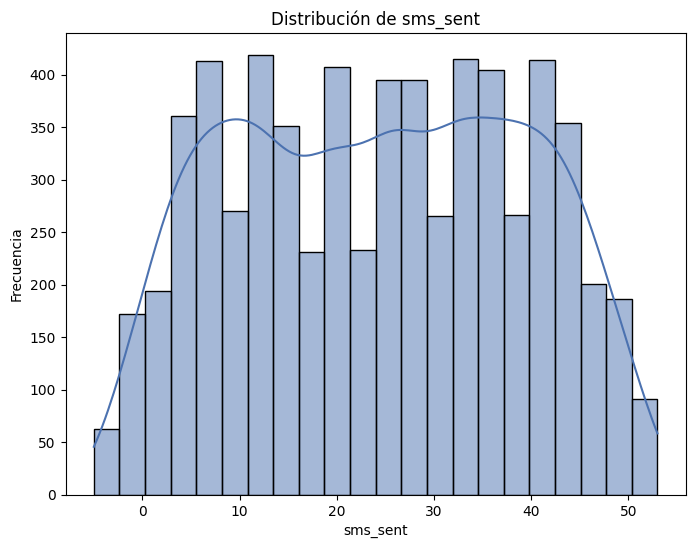

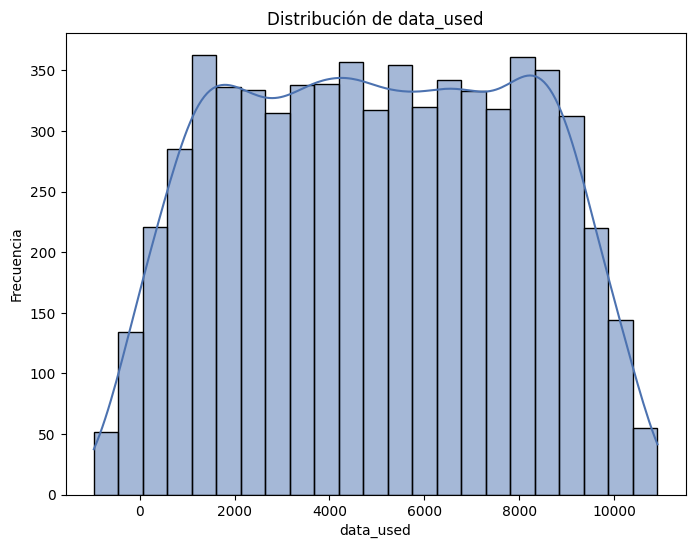

In [22]:
columnas_numericas = df_full.select_dtypes(include=['int', 'float']).columns

for columna in columnas_numericas:
    if columna not in ['churn', 'customer_id', 'num_dependents']:
        distribution_plot(df_full, columna)

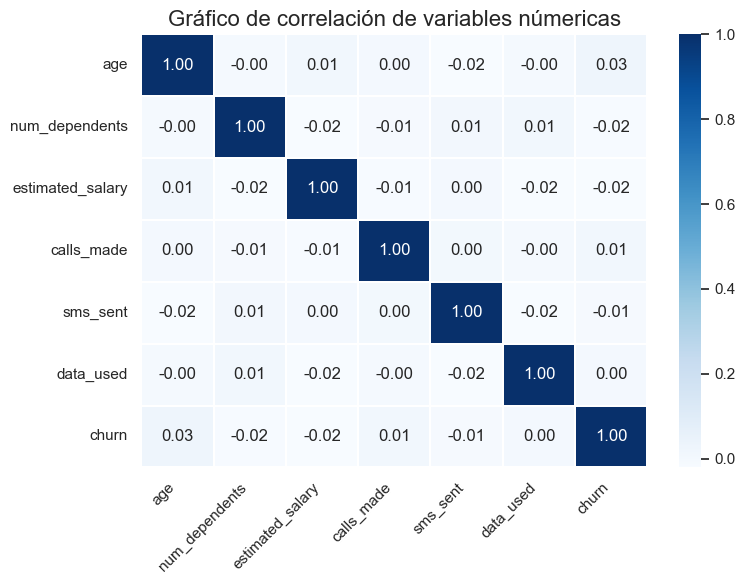

In [23]:
corr = df_full.corr(numeric_only=True)
plt.figure(figsize=(8, 6))  # Tamaño de la figura
sns.set(font_scale=1)  # Escala del tamaño de la fuente
sns.heatmap(corr, cmap='Blues', annot=True, fmt='.2f', linewidths=.2)

# Configuraciones adicionales (opcional)
plt.title('Gráfico de correlación de variables númericas', fontsize=16)
plt.xticks(rotation=45, ha='right')  # Rotación de etiquetas en el eje x
plt.yticks(rotation=0)  # Rotación de etiquetas en el eje y
plt.tight_layout()

# Mostrar el mapa de calor
plt.show()

No vemos ninguna relación directa o lineal con las variables númericas. Probemos con la variable de tiempo. Primero vamos a procesarla

In [24]:
df_full['registration_event'] = pd.to_datetime(df_full['registration_event']) #Convertimos a variable de tipo tiempo

df_full['year'] = df_full['registration_event'].dt.year #dividimos en año, mes y día
df_full['month'] = df_full['registration_event'].dt.month
df_full['day'] = df_full['registration_event'].dt.day
df_full.head(5)

,telecom_partner,gender,age,state,city,registration_event,num_dependents,estimated_salary,calls_made,sms_sent,data_used,churn,year,month,day
0,Airtel,F,26,Himachal Pradesh,Delhi,2020-03-16,4,85979,75,21,4532,1,2020,3,16
1,Airtel,F,74,Uttarakhand,Hyderabad,2022-01-16,0,69445,35,38,723,1,2022,1,16
2,Airtel,F,54,Jharkhand,Chennai,2022-01-11,2,75949,70,47,4688,1,2022,1,11
3,Reliance Jio,M,29,Bihar,Hyderabad,2022-07-26,3,34272,95,32,10241,1,2022,7,26
4,Vodafone,M,45,Nagaland,Bangalore,2020-03-11,4,34157,66,23,5246,1,2020,3,11


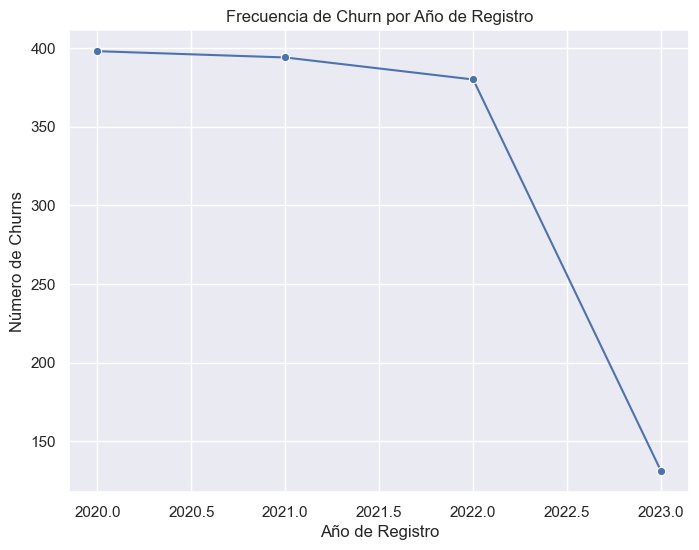

In [25]:
df_churn_by_year = df_full.groupby('year')['churn'].sum().reset_index()

# Gráfico de línea para visualizar la frecuencia de churn por año
plt.figure(figsize=(8, 6))
sns.lineplot(x='year', y='churn', data=df_churn_by_year, marker='o')
plt.title('Frecuencia de Churn por Año de Registro')
plt.xlabel('Año de Registro')
plt.ylabel('Número de Churns')
plt.show()


Es muy interesante ver que el año en el que llega la pandemia (2020) se produce la mayor cantidad de bajas y esto puede ser debido a que mucha gente tuvo que dejar de trabajar debido al confinamiento y decidió darse de baja del servicio para reducir costos.

In [26]:
df_pre_processed = df_full.copy()

In [27]:
le = LabelEncoder() # Instanciamos LaberEncoder

enc = OneHotEncoder(handle_unknown='ignore') # Instanciamos One Hot Encoder

df_pre_processed['telecom_partner'] = le.fit_transform(df_pre_processed['telecom_partner'])

df_pre_processed = pd.get_dummies(df_pre_processed, columns=['gender'], drop_first=True) # Eliminamos una columna para evitar la dummy_trap o tramp de las variables dummys

df_pre_processed['state'] = le.fit_transform(df_pre_processed['state'])

df_pre_processed['city'] = le.fit_transform(df_pre_processed['city'])

df_pre_processed = df_pre_processed.drop(axis=1, columns='registration_event')

In [28]:
df_pre_processed['gender_M'] = df_pre_processed.gender_M.replace({False: 0, True: 1})

In [29]:
columns = ['calls_made', 'sms_sent','data_used']

for column in columns: # Bucle for para recorrer las columnas con negativos
    df_pre_processed[column] = df_pre_processed[column].clip(lower=0)

In [30]:
numerical_columns = ['telecom_partner', 'age', 'state', 'city', 'num_dependents',
       'estimated_salary', 'calls_made', 'sms_sent', 'data_used', 'churn',
       'year', 'month', 'day']

scaler = MinMaxScaler()

for column in numerical_columns:
    df_pre_processed[column] = scaler.fit_transform(df_pre_processed[[column]])


In [31]:
df_pre_processed.head(5)

,telecom_partner,age,state,city,num_dependents,estimated_salary,calls_made,sms_sent,data_used,churn,year,month,day,gender_M
0,0.000000,0.142857,0.296296,0.4,1.00,0.507617,0.694444,0.396226,0.415056,1.0,0.000000,0.181818,0.500000,0
1,0.000000,1.000000,0.962963,0.6,0.00,0.380409,0.324074,0.716981,0.066215,1.0,0.666667,0.000000,0.500000,0
2,0.000000,0.642857,0.333333,0.2,0.50,0.430449,0.648148,0.886792,0.429343,1.0,0.666667,0.000000,0.333333,0
3,0.666667,0.196429,0.111111,0.6,0.75,0.109797,0.879630,0.603774,0.937906,1.0,0.666667,0.545455,0.833333,1
4,1.000000,0.482143,0.629630,0.0,1.00,0.108912,0.611111,0.433962,0.480447,1.0,0.000000,0.181818,0.333333,1


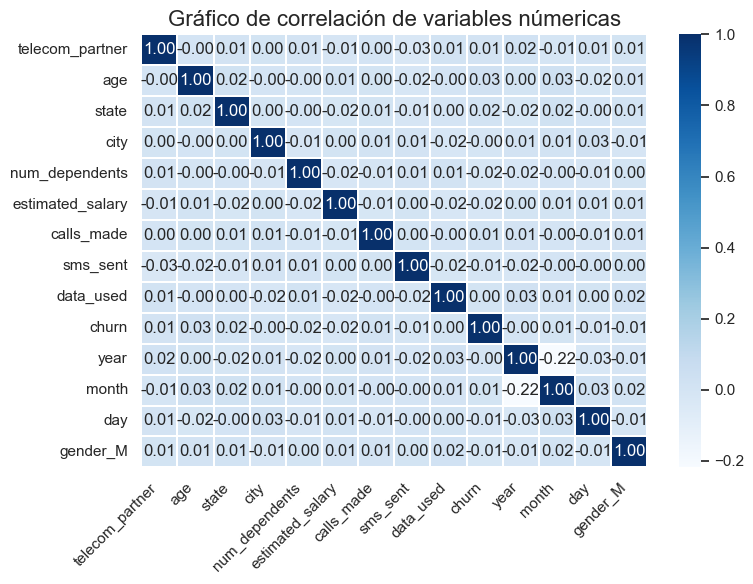

In [32]:
corr = df_pre_processed.corr()
plt.figure(figsize=(8, 6))  # Tamaño de la figura
sns.set(font_scale=1)  # Escala del tamaño de la fuente
sns.heatmap(corr, cmap='Blues', annot=True, fmt='.2f', linewidths=.2)

# Configuraciones adicionales (opcional)
plt.title('Gráfico de correlación de variables númericas', fontsize=16)
plt.xticks(rotation=45, ha='right')  # Rotación de etiquetas en el eje x
plt.yticks(rotation=0)  # Rotación de etiquetas en el eje y
plt.tight_layout()

# Mostrar el mapa de calor
plt.show()

In [33]:
X= df_pre_processed.drop(axis=1, columns='churn')
y= df_pre_processed['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, stratify=y, random_state=42)

In [34]:
from imblearn.under_sampling import RandomUnderSampler

undersampler = RandomUnderSampler(random_state=42)
X_train, y_train = undersampler.fit_resample(X_train, y_train)


In [35]:
# X_train.shape

In [36]:
# X_undersampled.shape

Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.79      0.53      0.64      1039
         1.0       0.20      0.45      0.27       261

    accuracy                           0.52      1300
   macro avg       0.49      0.49      0.45      1300
weighted avg       0.67      0.52      0.56      1300



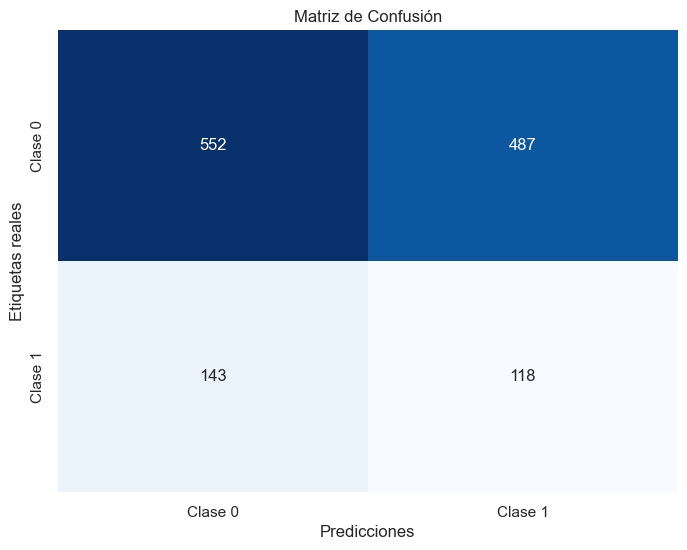

In [37]:
model = RandomForestClassifier()
y_pred = make_prediction(model, X_train, y_train, X_test)
verify_results(y_test, y_pred)

Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.82      0.53      0.64      1039
         1.0       0.22      0.54      0.32       261

    accuracy                           0.53      1300
   macro avg       0.52      0.53      0.48      1300
weighted avg       0.70      0.53      0.58      1300



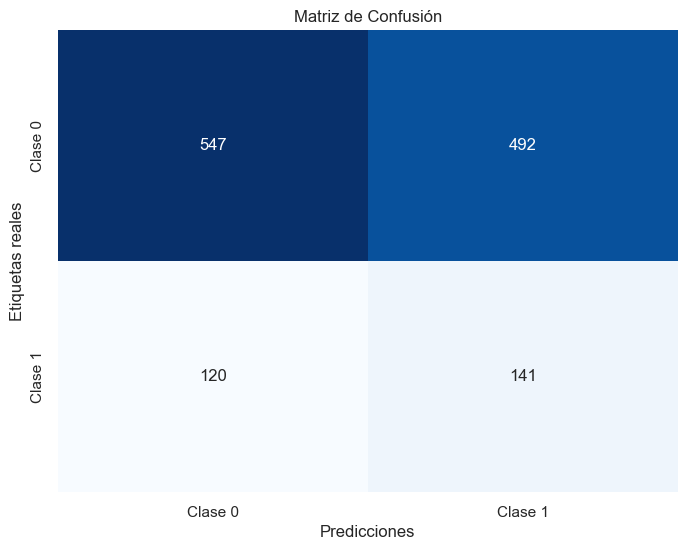

In [38]:
xgbc = XGBClassifier()

y_pred = make_prediction(xgbc, X_train, y_train, X_test)
verify_results(y_test, y_pred)

Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.81      0.52      0.63      1039
         1.0       0.21      0.51      0.30       261

    accuracy                           0.52      1300
   macro avg       0.51      0.52      0.47      1300
weighted avg       0.69      0.52      0.57      1300



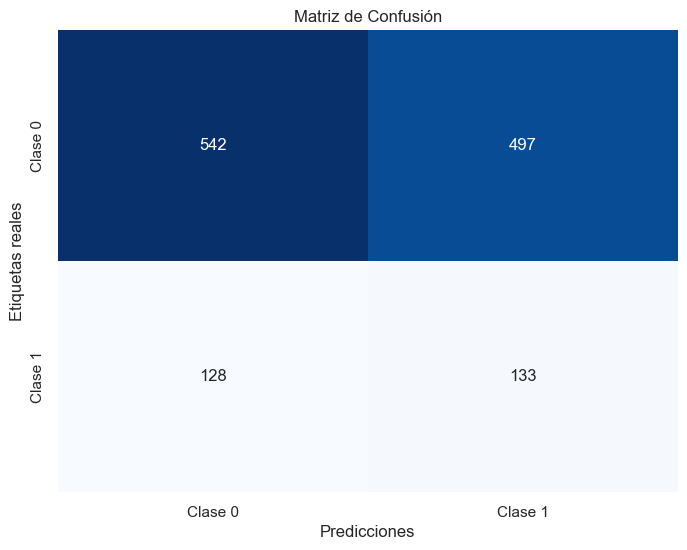

In [39]:
gb_classifier = GradientBoostingClassifier()

y_pred = make_prediction(gb_classifier, X_train, y_train, X_test)
verify_results(y_test, y_pred)

Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.81      0.51      0.62      1039
         1.0       0.21      0.52      0.30       261

    accuracy                           0.51      1300
   macro avg       0.51      0.51      0.46      1300
weighted avg       0.69      0.51      0.56      1300



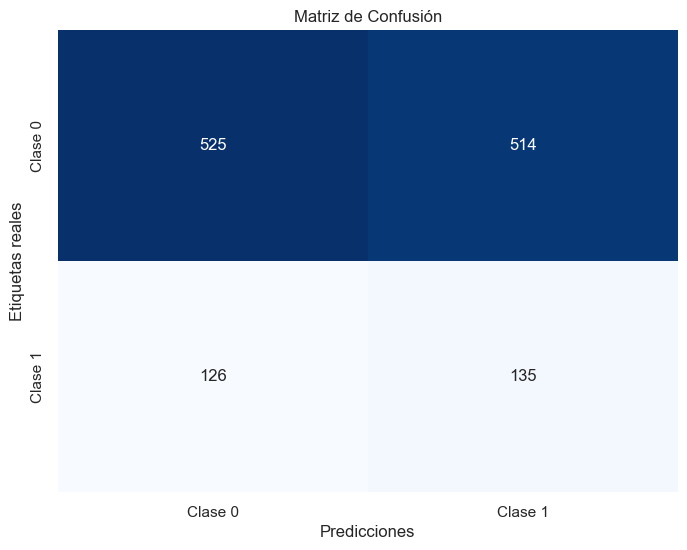

In [40]:
# Instanciar el clasificador AdaBoost
adaboost_classifier = AdaBoostClassifier()

y_pred = make_prediction(adaboost_classifier, X_train, y_train, X_test)
verify_results(y_test, y_pred)


In [41]:
from sklearn.metrics import make_scorer, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Definir los hiperparámetros y sus valores a considerar
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ["auto", "sqrt", "log2"]
}

# Instanciar el clasificador RandomForest
rf_classifier = RandomForestClassifier(random_state=42)

# Definir la métrica a optimizar (recall)
scorer = make_scorer(recall_score)

# Realizar una búsqueda de hiperparámetros mediante validación cruzada
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring=scorer)
grid_search.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", grid_search.best_params_)

# Obtener el mejor modelo
best_rf_model = grid_search.best_estimator_

# Evaluar el modelo en datos de prueba
y_pred = best_rf_model.predict(X_test)

# Calcular la sensibilidad (recall)
recall = recall_score(y_test, y_pred)
print("Sensibilidad (Recall):", recall)


KeyboardInterrupt: 

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import make_scorer, recall_score
from sklearn.model_selection import GridSearchCV

# Definir los hiperparámetros y sus valores a considerar
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# Instanciar el clasificador Gradient Boosting
gb_classifier = GradientBoostingClassifier(random_state=42)

# Definir la métrica a optimizar (recall)
scorer = make_scorer(recall_score)

# Realizar una búsqueda de hiperparámetros mediante validación cruzada
grid_search = GridSearchCV(estimator=gb_classifier, param_grid=param_grid, cv=5, scoring=scorer)
grid_search.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", grid_search.best_params_)

# Obtener el mejor modelo
best_gb_model = grid_search.best_estimator_

# Evaluar el modelo en datos de prueba
y_pred = best_gb_model.predict(X_test)

# Calcular la sensibilidad (recall)
recall = recall_score(y_test, y_pred)
print("Sensibilidad (Recall):", recall)


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, recall_score
from sklearn.model_selection import GridSearchCV

# Definir los hiperparámetros y sus valores a considerar
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0]
}

# Instanciar el clasificador XGBoost
xgb_classifier = XGBClassifier(random_state=42)

# Definir la métrica a optimizar (recall)
scorer = make_scorer(recall_score)

# Realizar una búsqueda de hiperparámetros mediante validación cruzada
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=5, scoring=scorer)
grid_search.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", grid_search.best_params_)

# Obtener el mejor modelo
best_xgb_model = grid_search.best_estimator_

# Evaluar el modelo en datos de prueba
y_pred = best_xgb_model.predict(X_test)

# Calcular la sensibilidad (recall)
recall = recall_score(y_test, y_pred)
print("Sensibilidad (Recall):", recall)


In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import make_scorer, recall_score
from sklearn.model_selection import GridSearchCV

# Definir los hiperparámetros y sus valores a considerar
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Instanciar el clasificador AdaBoost
adaboost_classifier = AdaBoostClassifier(random_state=42)

# Definir la métrica a optimizar (recall)
scorer = make_scorer(recall_score)

# Realizar una búsqueda de hiperparámetros mediante validación cruzada
grid_search = GridSearchCV(estimator=adaboost_classifier, param_grid=param_grid, cv=5, scoring=scorer)
grid_search.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", grid_search.best_params_)

# Obtener el mejor modelo
best_adaboost_model = grid_search.best_estimator_

# Evaluar el modelo en datos de prueba
y_pred = best_adaboost_model.predict(X_test)

# Calcular la sensibilidad (recall)
recall = recall_score(y_test, y_pred)
print("Sensibilidad (Recall):", recall)
